# Project
In this project I used PyTorch to build and implement a MLP model for solving a classification problem. My goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. I used [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.



# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import os
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('ggplot')


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data 

In [5]:
# download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df['class_label'].unique()

efigi_png downloaded!
efigi_tables downloaded!


array([2, 1, 0, 3])

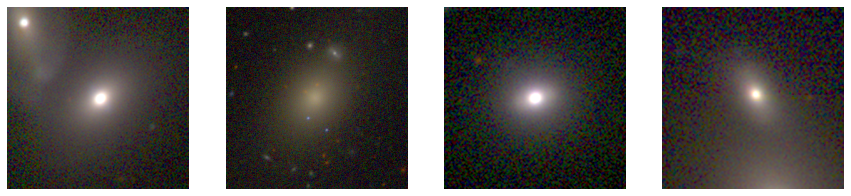

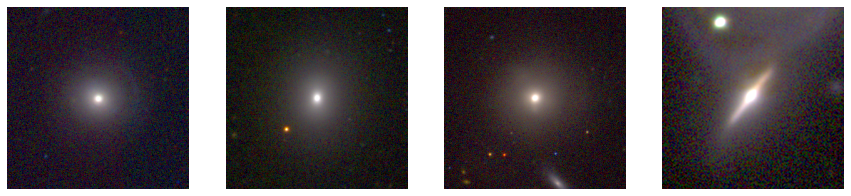

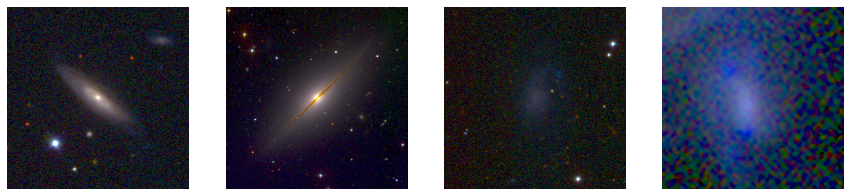

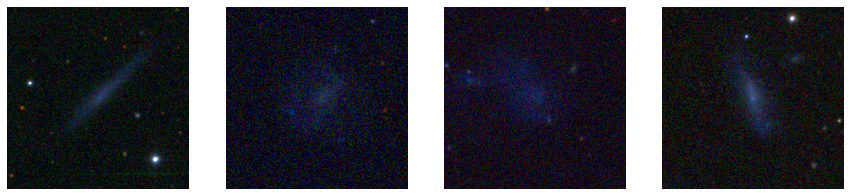

In [13]:

IMG_DIR = "efigi-1.6/png"
def show_image(num, df):
    plt.figure(figsize=(15, 15))
    n = 4
    lst = df[df['class_label'] == num][:4]['name'].values
    for i in range(n):
        plt.subplot(1, n, i+1)
        img_path = os.path.join(IMG_DIR, lst[i] + ".png")
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
show_image(0, df)
show_image(1, df)
show_image(2, df)
show_image(3, df)


# Define Dataset (20 Points)

In [14]:

class GalaxyDataSet(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        query = "efigi-1.6/png/" + self.X.iloc[idx]['name'] + ".png"
        img_path = os.path.join(query)
        image = read_image(img_path)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_pil = Image.fromarray(img_array)
        img_28x28 = np.array(img_pil.resize((28, 28), Image.ANTIALIAS))
        label = self.y.iloc[idx]
        return (
            img_28x28,
            label,
        )



X_train, X_test, y_train, y_test = train_test_split(df.drop('class_label',axis = 1), df['class_label'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

train_dataset = GalaxyDataSet(X_train, y_train)
test_dataset = GalaxyDataSet(X_test, y_test)
valid_dataset = GalaxyDataSet(X_valid, y_valid)

# Define Model (20 Points)

In [15]:

def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),
            nn.ReLU(inplace=True)]

class FullyConnected(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FullyConnected, self).__init__()
        self.classifier =  nn.Sequential(
            *linear_relu(input_size, 256),
            *linear_relu(256, 256),
            *linear_relu(256, 256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        y = self.classifier(x)
        
        return y

# Train Model (30 Points)

In [16]:
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


In [17]:
def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [18]:
def test(model, loader, f_loss, device):
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.to(torch.float32)
            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N

In [19]:

model=FullyConnected(28*28, 4)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
f_loss = torch.nn.CrossEntropyLoss()

In [20]:
val_loss_lst = []
val_acc_lst = []
train_loss_lst = []
train_acc_lst = []
epochs = 50
for t in range(epochs):
    print("Epoch {}".format(t))
    train(model, trainloader, f_loss, optimizer, device)
    val_loss, val_acc = test(model, validloader, f_loss, device)
    train_loss, train_acc = test(model, trainloader, f_loss, device)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))


Epoch 0
 Training : Loss : 0.9110, Acc : 0.7391
 Validation : Loss : 0.8726, Acc : 0.7549
Epoch 1
 Training : Loss : 0.8008, Acc : 0.7430
 Validation : Loss : 0.7457, Acc : 0.7549
Epoch 2
 Training : Loss : 0.7635, Acc : 0.7381
 Validation : Loss : 0.7451, Acc : 0.7493
Epoch 3
 Training : Loss : 0.6720, Acc : 0.7616
 Validation : Loss : 0.6192, Acc : 0.7675
Epoch 4
 Training : Loss : 0.6635, Acc : 0.7598
 Validation : Loss : 0.6636, Acc : 0.7605
Epoch 5
 Training : Loss : 0.6602, Acc : 0.7805
 Validation : Loss : 0.6715, Acc : 0.7661
Epoch 6
 Training : Loss : 0.6167, Acc : 0.7679
 Validation : Loss : 0.6208, Acc : 0.7409
Epoch 7
 Training : Loss : 0.6207, Acc : 0.7861
 Validation : Loss : 0.6116, Acc : 0.7717
Epoch 8
 Training : Loss : 0.5482, Acc : 0.7956
 Validation : Loss : 0.5694, Acc : 0.7815
Epoch 9
 Training : Loss : 0.5490, Acc : 0.7784
 Validation : Loss : 0.5625, Acc : 0.7857
Epoch 10
 Training : Loss : 0.5626, Acc : 0.7896
 Validation : Loss : 0.6128, Acc : 0.7549
Epoch 11


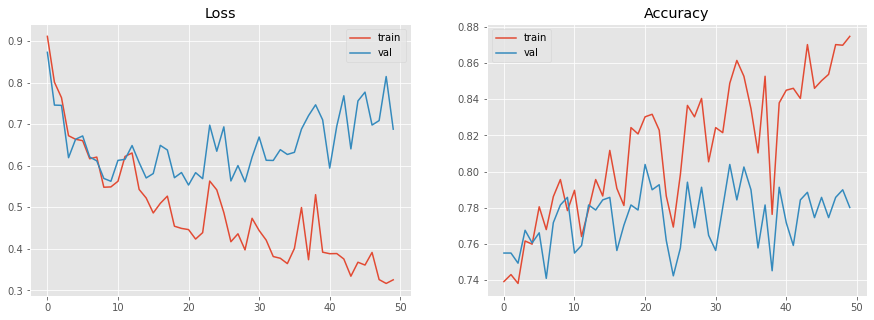

In [21]:
# fig = plt.figure(figsize = (20,10))
# plt.plot(range(epochs), val_loss_lst, label = "Validation Loss")
# plt.plot(range(epochs), val_acc_lst, label = "Validation Accuracy")
# plt.plot(range(epochs), train_loss_lst, label = "Training Loss")
# plt.plot(range(epochs), train_acc_lst, label = "Training Accuracy")

# plt.legend()
# plt.show()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_lst, label='train')
plt.plot(val_loss_lst, label='val')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_lst, label='train')
plt.plot(val_acc_lst, label='val')
plt.legend()
plt.title('Accuracy')
plt.show()



# Test Model (20)

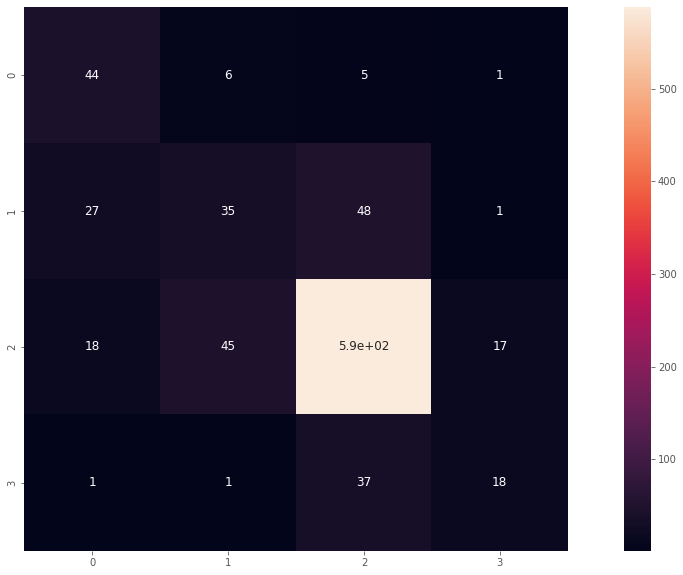

In [28]:
import seaborn as sn
predicted_target = []
targets_lst = []
with torch.no_grad():
    model.eval()
    N = 0
    for i, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.to(torch.float32)
        outputs = model(inputs)
        N += inputs.shape[0]
        predicted_target.append(outputs.argmax(dim=1))
        targets_lst.append(targets)
    predicted_target = torch.cat(predicted_target, dim=0)
    targets_lst = torch.cat(targets_lst, dim=0)
confusion = confusion_matrix(targets_lst.cpu().numpy(), predicted_target.cpu().numpy())
plt.figure(figsize=(20,10))
sn.heatmap(confusion, annot=True, square=True, annot_kws={'size': 12})


In [30]:
# print(accuracy = accuracy_score(targets_lst.cpu().numpy(), predicted_target.cpu().numpy()))
print(classification_report(targets_lst.cpu().numpy(), predicted_target.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.49      0.79      0.60        56
           1       0.40      0.32      0.35       111
           2       0.87      0.88      0.87       668
           3       0.49      0.32      0.38        57

    accuracy                           0.77       892
   macro avg       0.56      0.57      0.55       892
weighted avg       0.76      0.77      0.76       892



## F1 macro avg = 0.55!